In [126]:
import math, random

import gym
import numpy as np
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
from torch.autograd import Variable
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [144]:

ckpt_dir = './checkpoints_base'
recent_checkpoint = ckpt_dir + '/' +'840000_DoubleDQN.ckpt'
ckpt_names = []
files = os.listdir(ckpt_dir)
files.sort()

file_with_ext = []
for foo in files:
    file_with_ext.append(ckpt_dir + '/' + foo)

ckpt_names = sorted(file_with_ext,key=os.path.getctime)
ckpt_names.pop
ckpt_names

['./checkpoints_base/10000_DoubleDQN.ckpt',
 './checkpoints_base/20000_DoubleDQN.ckpt',
 './checkpoints_base/30000_DoubleDQN.ckpt',
 './checkpoints_base/40000_DoubleDQN.ckpt',
 './checkpoints_base/50000_DoubleDQN.ckpt',
 './checkpoints_base/60000_DoubleDQN.ckpt',
 './checkpoints_base/70000_DoubleDQN.ckpt',
 './checkpoints_base/80000_DoubleDQN.ckpt',
 './checkpoints_base/90000_DoubleDQN.ckpt',
 './checkpoints_base/100000_DoubleDQN.ckpt',
 './checkpoints_base/110000_DoubleDQN.ckpt',
 './checkpoints_base/120000_DoubleDQN.ckpt',
 './checkpoints_base/130000_DoubleDQN.ckpt',
 './checkpoints_base/140000_DoubleDQN.ckpt',
 './checkpoints_base/150000_DoubleDQN.ckpt',
 './checkpoints_base/160000_DoubleDQN.ckpt',
 './checkpoints_base/170000_DoubleDQN.ckpt',
 './checkpoints_base/180000_DoubleDQN.ckpt',
 './checkpoints_base/190000_DoubleDQN.ckpt',
 './checkpoints_base/200000_DoubleDQN.ckpt',
 './checkpoints_base/210000_DoubleDQN.ckpt',
 './checkpoints_base/220000_DoubleDQN.ckpt',
 './checkpoints_bas

In [128]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [129]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Double Deep Q Network</h2>

<h3>Synchronize current policy net and target net</h3>

In [130]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

<h2>Computing Temporal Difference Loss</h2>

In [131]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## Testing

In [132]:
def plot_test(ckpt, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Test checkpoint %s. reward: %s' % (ckpt, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.show()

<h1>Atari Environment</h1>

In [133]:
from wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [134]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [135]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action

In [136]:
current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
current_model.load_state_dict(torch.load('checkpoints_base/810000_DoubleDQN.ckpt'))
target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)
target_model.load_state_dict(torch.load('checkpoints_base/810000_DoubleDQN.ckpt'))

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    

update_target(current_model, target_model)

In [137]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in current_model.state_dict():
    print(param_tensor, "\t", current_model.state_dict()[param_tensor].size())

Model's state_dict:
features.0.weight 	 torch.Size([32, 1, 8, 8])
features.0.bias 	 torch.Size([32])
features.2.weight 	 torch.Size([64, 32, 4, 4])
features.2.bias 	 torch.Size([64])
features.4.weight 	 torch.Size([64, 64, 3, 3])
features.4.bias 	 torch.Size([64])
fc.0.weight 	 torch.Size([512, 3136])
fc.0.bias 	 torch.Size([512])
fc.2.weight 	 torch.Size([6, 512])
fc.2.bias 	 torch.Size([6])


## Testing with Visualization

In [138]:
from wrappers import make_atari, wrap_deepmind, wrap_pytorch
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [139]:
env.observation_space.shape

(1, 84, 84)

In [140]:
# # Loading Checkpoints

# # current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
# # target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)

# current_model_Atari = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
# current_model_Atari.load_state_dict(torch.load('current.ckpt'))

# target_model_Atari = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
# target_model_Atari.load_state_dict(torch.load('target.ckpt'))

In [141]:
# env_id = "CartPole-v0"
# No exploring, only playin to the model for Testing
epsilon=0
# done=False

def test(model):
    done=False
    model.eval()
    
    env = make_atari(env_id)
    env = wrap_deepmind(env)
    env = wrap_pytorch(env)
    
    state = env.reset()
    #env.render()
    
    testReward=0
    
    while not done:
#         for frame_idx in range(1, num_frames + 1):=
#         epsilon = epsilon_by_frame(frame_idx)
        action = model.act(state, epsilon)

        next_state, reward, done, _ = env.step(action)
        #env.render()

        state = next_state
        testReward += reward
    state = env.reset()
    if done:
        env.close()

    return testReward


## Run Results for Every Checkpoint

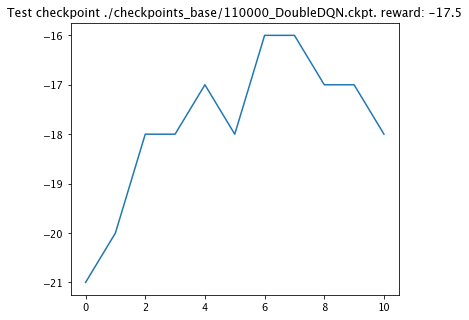

KeyboardInterrupt: 

In [142]:

rewards = []
for ckpt in ckpt_names:
    load_ckpt = ckpt
    # Load the Model
    current_model = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
    current_model.load_state_dict(torch.load(load_ckpt))
    
    # run the loaded model, save the output
    r = test(current_model)

    rewards.append(r)
    plot_test(ckpt, rewards)

## Run Results for 10k frames of last Ckpt 

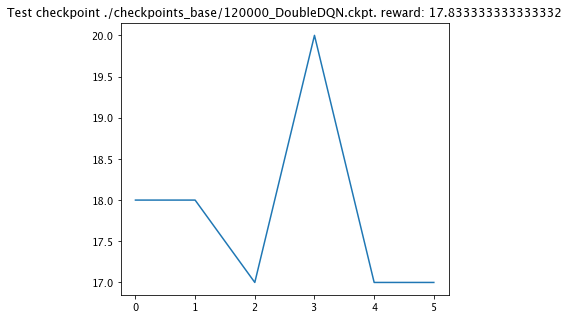

KeyboardInterrupt: 

In [145]:
rewards = []
for frame in range(10000):
    # Load the Model
    current_model = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
    current_model.load_state_dict(torch.load(recent_checkpoint))
    
    # run the loaded model, save the output
    r = test(current_model)

    rewards.append(r)
    plot_test(recent_checkpoint, rewards)